In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

In [2]:
data = pd.read_csv('../data/seattle_sample_3k.csv')

In [3]:
data = gpd.GeoDataFrame(data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

In [4]:
data = data.to_crs(4326)

In [5]:
data['lon'] = data['geometry'].get_coordinates()['x']

In [6]:
data['lat'] = data['geometry'].get_coordinates()['y']

In [7]:
data['price'] = np.power(10, data['log_price']) / 10000

In [8]:
y = data.price
X = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y']]
loc = data[['lon', 'lat']]

In [9]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(X, y, loc, train_size=0.8, random_state=42)

In [10]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [11]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)

In [12]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
explainer = GeoConformalizedExplainer(model, X_train, X_calib, loc_calib.values, loc_test.values, 0.1, 0.15)

In [14]:
results = explainer.uncertainty_aware_explain(x_test=X_test)

100%|██████████| 10/10 [01:00<00:00,  6.04s/it]


In [15]:
results.accuracy_summary()

,coverage_probability,R2,RMSE
bathrooms,0.923333,0.585514,1.155932
sqft_living,0.910000,0.976250,1.615880
sqft_lot,0.943333,0.921574,1.422857
grade,0.933333,0.994399,0.709026
condition,0.896667,0.938544,0.472674
waterfront,0.906667,0.976651,0.815460
view,0.940000,0.956973,1.108449
age,0.920000,0.728275,1.459942
UTM_X,0.933333,0.915114,1.175810
UTM_Y,0.926667,0.985680,1.827590


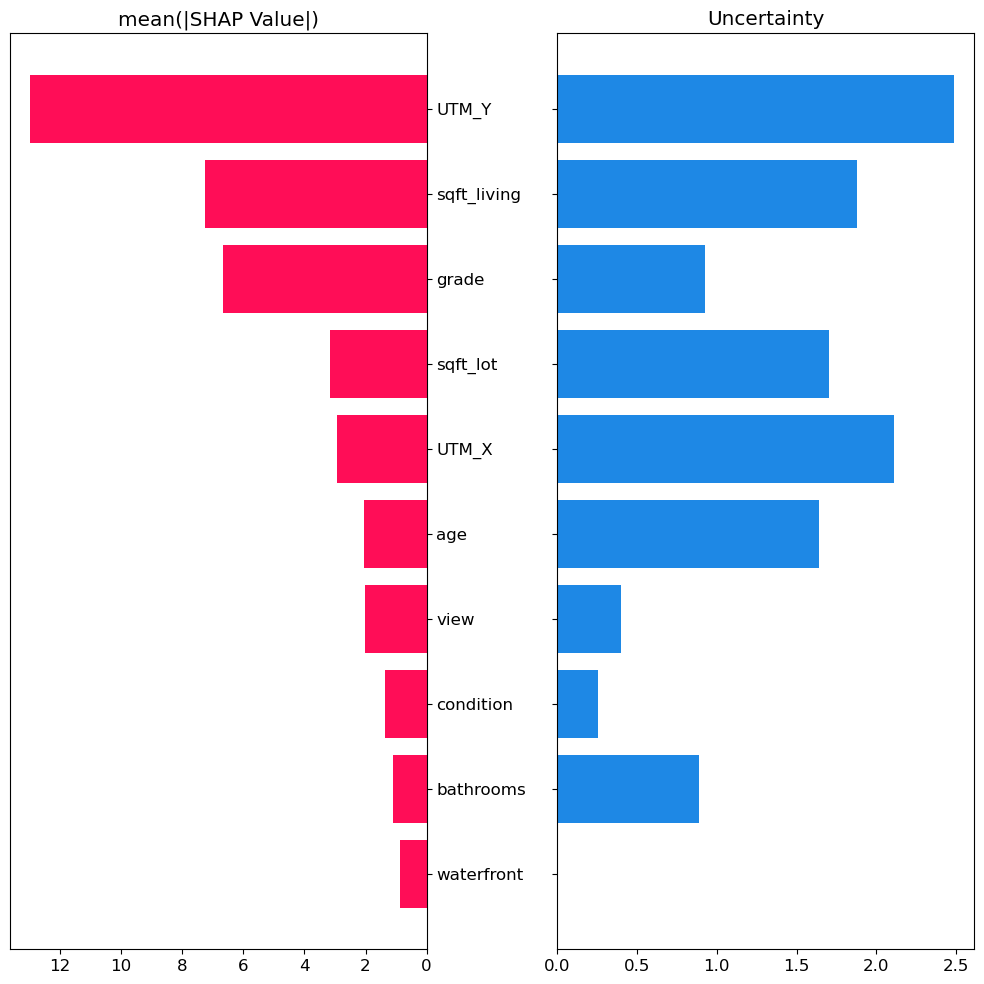

In [16]:
results.plot_absolute_shap_value_with_uncertainty()

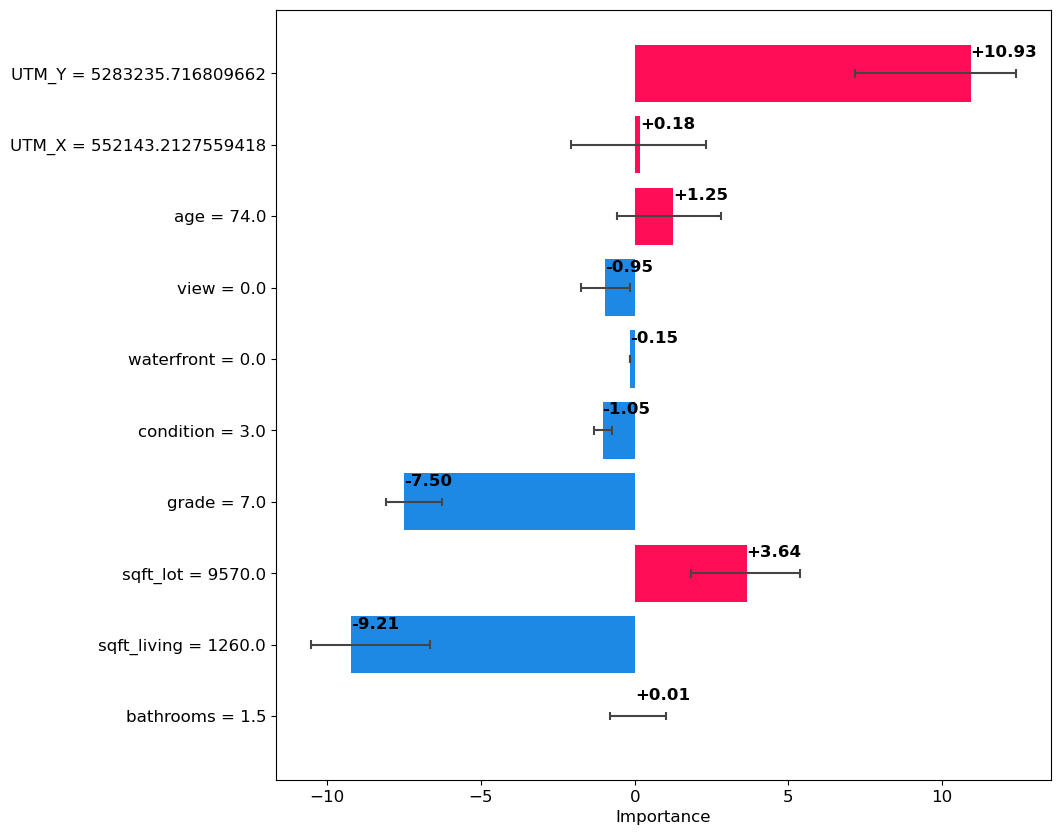

In [17]:
results.plot_shap_values_with_uncertainty(20)

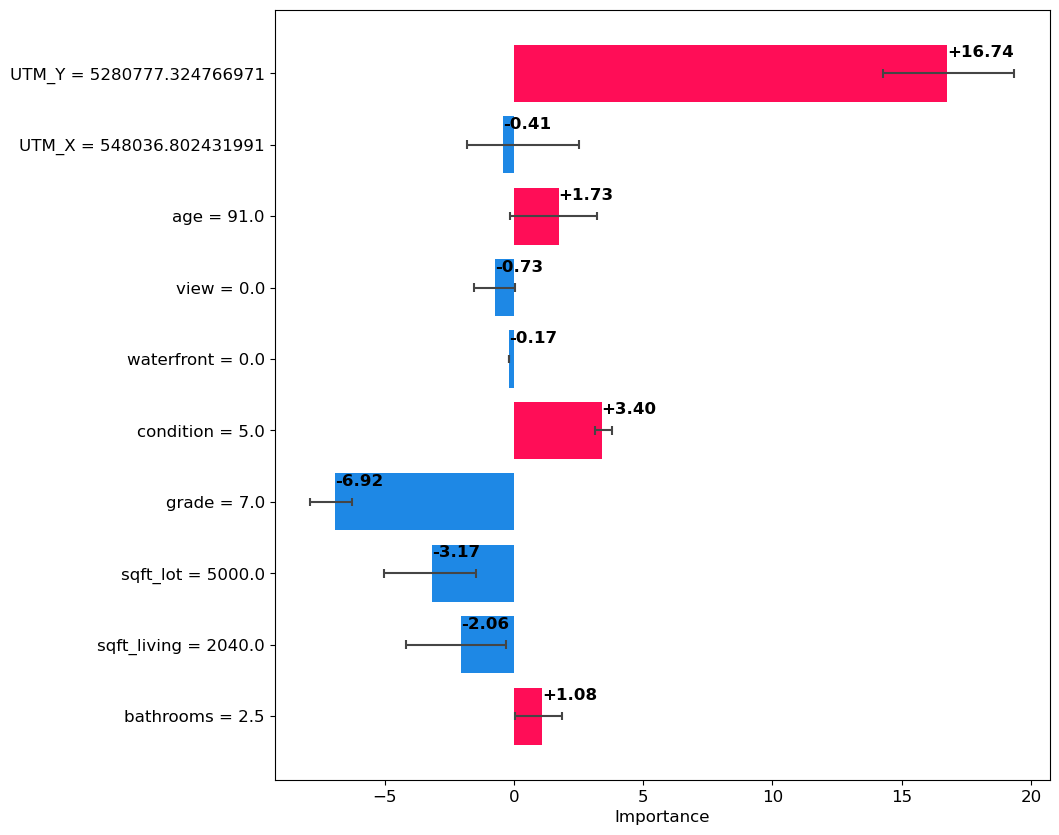

In [18]:
results.plot_shap_values_with_uncertainty(40)